In [85]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ultralytics import YOLO
import yaml

## Конфигурация 

In [86]:
class Config:
    DATASET_DIR = "dataset"
    ANNOT_FILE = "_annotations.csv"
    MODEL_NAME = "yolov8n.pt"
    IMG_SIZE = 640
    EPOCHS = 100
    BATCH = 4
    DEVICE = "cuda:1" 
    
    AUGMENTATIONS = {
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'translate': 0.1,
        'scale': 0.5,
        'fliplr': 0.5,
        'mosaic': 1.0,
        'mixup': 0.1
    }


## Загружка и подготовка данных

In [87]:
def prepare_data():
    # Создание структуры папок
    os.makedirs("yolo_dataset/images/train", exist_ok=True)
    os.makedirs("yolo_dataset/images/val", exist_ok=True)
    os.makedirs("yolo_dataset/labels/train", exist_ok=True)
    os.makedirs("yolo_dataset/labels/val", exist_ok=True)

    # Загрузка аннотаций
    df = pd.read_csv(Config.ANNOT_FILE)
    
    # Разделение данных
    from sklearn.model_selection import train_test_split
    train_files, val_files = train_test_split(
        df["filename"].unique(), 
        test_size=0.2, 
        random_state=42
    )
    
    # Функция конвертации в YOLO формат
    def convert_to_yolo(row):
        x_center = (row["xmin"] + row["xmax"]) / 2 / row["width"]
        y_center = (row["ymin"] + row["ymax"]) / 2 / row["height"]
        width = (row["xmax"] - row["xmin"]) / row["width"]
        height = (row["ymax"] - row["ymin"]) / row["height"]
        return f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
    
    # Обработка файлов
    for split, files in [("train", train_files), ("val", val_files)]:
        for file in files:
            # Копирование изображений
            img = cv2.imread(os.path.join(Config.DATASET_DIR, file))
            if img is not None:
                cv2.imwrite(f"yolo_dataset/images/{split}/{file}", img)
            
            # Создание аннотаций
            with open(f"yolo_dataset/labels/{split}/{file.replace('.jpg', '.txt')}", "w") as f:
                for _, row in df[df["filename"] == file].iterrows():
                    f.write(convert_to_yolo(row) + "\n")
    
    # Создание YAML
    yaml_content = {
        'path': os.path.abspath("yolo_dataset"),
        'train': 'images/train',
        'val': 'images/val',
        'names': {0: 'human'},
        'augment': Config.AUGMENTATIONS
    }
    
    with open("yolo_dataset/dataset.yaml", "w") as f:
        yaml.dump(yaml_content, f)

prepare_data()
print("Подготовка данных завершена")

Подготовка данных завершена


## Обучение

In [88]:
def train_model():
    # Инициализация модели
    model = YOLO(Config.MODEL_NAME)
    
    # Обучение
    results = model.train(
        data="yolo_dataset/dataset.yaml",
        epochs=Config.EPOCHS,
        batch=Config.BATCH,
        imgsz=Config.IMG_SIZE,
        device=Config.DEVICE,
        augment=True,
        plots=True,
        verbose=True
    )
    return model

model = train_model()

New https://pypi.org/project/ultralytics/8.3.141 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimiz

train: Scanning /home/v.chernodolya/introduction_to_ai/heridal/yolo_dataset/labels/train.cache... 788 images, 0 backgrounds, 0 corrupt: 100%|██████████| 788/788 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2174.6±1732.5 MB/s, size: 4962.3 KB)


val: Scanning /home/v.chernodolya/introduction_to_ai/heridal/yolo_dataset/labels/val.cache... 197 images, 0 backgrounds, 0 corrupt: 100%|██████████| 197/197 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.1G      2.969      7.487       1.04         10        640: 100%|██████████| 197/197 [00:17<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 21.31it/s]

                   all        197        646      0.446      0.375      0.321     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.13G       2.92       4.26      1.009          8        640: 100%|██████████| 197/197 [00:16<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 15.21it/s]

                   all        197        646      0.433      0.418      0.327     0.0913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.13G      2.871      3.295     0.9766         28        640: 100%|██████████| 197/197 [00:16<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 23.40it/s]

                   all        197        646      0.459      0.404      0.365      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.13G      2.848       2.85     0.9863          7        640: 100%|██████████| 197/197 [00:15<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.42it/s]


                   all        197        646       0.42      0.393      0.339      0.103

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.13G      2.809      2.507     0.9674         15        640: 100%|██████████| 197/197 [00:16<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.63it/s]

                   all        197        646      0.473      0.481      0.383      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.16G      2.792      2.324     0.9594         22        640: 100%|██████████| 197/197 [00:16<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.66it/s]


                   all        197        646      0.475      0.478      0.394      0.124

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.16G      2.722      2.113     0.9567          5        640: 100%|██████████| 197/197 [00:16<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]


                   all        197        646      0.481       0.46      0.431      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.16G       2.72      1.934     0.9561         28        640: 100%|██████████| 197/197 [00:16<00:00, 12.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.37it/s]


                   all        197        646      0.528      0.494      0.459      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.16G      2.675      1.863     0.9546         35        640: 100%|██████████| 197/197 [00:15<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 20.89it/s]

                   all        197        646      0.494      0.497      0.446      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.16G      2.658      1.877       0.95         24        640: 100%|██████████| 197/197 [00:16<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.98it/s]

                   all        197        646      0.497      0.515      0.449      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.16G       2.68      1.831     0.9456          6        640: 100%|██████████| 197/197 [00:16<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.89it/s]


                   all        197        646      0.572      0.492      0.489       0.16

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.16G      2.601      1.714     0.9472          8        640: 100%|██████████| 197/197 [00:15<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.76it/s]

                   all        197        646      0.538        0.5      0.496      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.16G      2.623      1.804     0.9379         31        640: 100%|██████████| 197/197 [00:15<00:00, 12.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]


                   all        197        646      0.569      0.472      0.489       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.16G      2.571      1.682     0.9381         15        640: 100%|██████████| 197/197 [00:14<00:00, 13.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.94it/s]

                   all        197        646       0.56      0.502      0.519      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.16G      2.552       1.72     0.9311         20        640: 100%|██████████| 197/197 [00:16<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.23it/s]

                   all        197        646      0.551      0.482      0.505      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.16G      2.485      1.678     0.9188         28        640: 100%|██████████| 197/197 [00:16<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]

                   all        197        646      0.583      0.526      0.543      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.16G      2.573      1.697     0.9368          9        640: 100%|██████████| 197/197 [00:16<00:00, 11.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 14.08it/s]

                   all        197        646      0.548      0.562      0.528      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.16G      2.576      1.657     0.9306          6        640: 100%|██████████| 197/197 [00:15<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 19.64it/s]

                   all        197        646       0.58      0.526       0.53      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.16G      2.503      1.596      0.919         18        640: 100%|██████████| 197/197 [00:15<00:00, 12.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.91it/s]


                   all        197        646      0.572      0.548      0.536      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.16G       2.48      1.631     0.9252         17        640: 100%|██████████| 197/197 [00:14<00:00, 13.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 20.64it/s]

                   all        197        646        0.6      0.556      0.555      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.16G      2.498      1.581     0.9194         11        640: 100%|██████████| 197/197 [00:15<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.77it/s]

                   all        197        646      0.636       0.55      0.577      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.16G      2.496      1.629      0.921         21        640: 100%|██████████| 197/197 [00:15<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.78it/s]


                   all        197        646       0.58      0.542      0.569      0.217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.16G      2.478      1.515     0.9177         11        640: 100%|██████████| 197/197 [00:16<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.51it/s]

                   all        197        646      0.644      0.584      0.584      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.16G      2.421      1.572     0.9185         21        640: 100%|██████████| 197/197 [00:16<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.89it/s]

                   all        197        646      0.594      0.556      0.561      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.16G      2.406      1.491     0.9143         11        640: 100%|██████████| 197/197 [00:13<00:00, 14.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 13.18it/s]

                   all        197        646      0.489      0.514      0.469      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.16G      2.411      1.487     0.9048         17        640: 100%|██████████| 197/197 [00:15<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 15.09it/s]

                   all        197        646      0.602      0.585      0.566      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.16G      2.441      1.501     0.9266         28        640: 100%|██████████| 197/197 [00:15<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 14.23it/s]

                   all        197        646      0.588      0.547      0.551      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.16G      2.447      1.557     0.9123         16        640: 100%|██████████| 197/197 [00:16<00:00, 12.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.93it/s]

                   all        197        646       0.58      0.467      0.504      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.16G      2.374      1.431     0.9186          6        640: 100%|██████████| 197/197 [00:16<00:00, 12.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.59it/s]

                   all        197        646      0.557      0.546      0.548      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.16G      2.513       1.53     0.9067         13        640: 100%|██████████| 197/197 [00:15<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.96it/s]

                   all        197        646      0.568      0.526      0.528      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.16G      2.445      1.457     0.9032         32        640: 100%|██████████| 197/197 [00:14<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.55it/s]

                   all        197        646      0.612      0.594       0.59      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.16G      2.362       1.41      0.906         11        640: 100%|██████████| 197/197 [00:16<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.87it/s]


                   all        197        646      0.603      0.554      0.574      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.16G      2.357      1.421     0.9058         15        640: 100%|██████████| 197/197 [00:16<00:00, 11.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.77it/s]

                   all        197        646      0.644      0.591       0.63      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.16G      2.432      1.456     0.9055         23        640: 100%|██████████| 197/197 [00:16<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]

                   all        197        646      0.644      0.505      0.562      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.16G      2.422      1.423      0.913         13        640: 100%|██████████| 197/197 [00:16<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.46it/s]

                   all        197        646      0.694      0.564      0.625      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.16G      2.344      1.407     0.9047         23        640: 100%|██████████| 197/197 [00:14<00:00, 13.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.76it/s]

                   all        197        646      0.665      0.559      0.609      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.16G      2.313      1.386      0.898         10        640: 100%|██████████| 197/197 [00:16<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.18it/s]


                   all        197        646      0.634      0.509      0.563      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.16G      2.296      1.369     0.8923         11        640: 100%|██████████| 197/197 [00:15<00:00, 12.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.79it/s]

                   all        197        646      0.599      0.582      0.593      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.16G      2.269      1.343     0.9117          6        640: 100%|██████████| 197/197 [00:15<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 22.21it/s]

                   all        197        646      0.687      0.565      0.641       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.16G       2.32      1.381     0.8967         23        640: 100%|██████████| 197/197 [00:15<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.87it/s]


                   all        197        646      0.661      0.559      0.617       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.16G      2.307       1.38     0.9008         25        640: 100%|██████████| 197/197 [00:15<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.43it/s]


                   all        197        646      0.639      0.597      0.612      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.16G       2.29      1.336     0.8959          9        640: 100%|██████████| 197/197 [00:14<00:00, 13.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.80it/s]


                   all        197        646      0.661      0.564      0.634      0.256

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.16G      2.303      1.327     0.8952         16        640: 100%|██████████| 197/197 [00:16<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.82it/s]

                   all        197        646      0.639       0.54      0.572      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.16G      2.292      1.358     0.8941         39        640: 100%|██████████| 197/197 [00:16<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.56it/s]

                   all        197        646      0.617      0.553      0.585      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.16G      2.288      1.344     0.8906         17        640: 100%|██████████| 197/197 [00:16<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.74it/s]

                   all        197        646      0.675      0.573      0.634      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.16G      2.286      1.289     0.8904         16        640: 100%|██████████| 197/197 [00:15<00:00, 12.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.71it/s]

                   all        197        646       0.67      0.598      0.652       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.16G      2.284      1.368     0.8952         26        640: 100%|██████████| 197/197 [00:13<00:00, 14.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.89it/s]


                   all        197        646      0.631      0.602       0.63      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.16G      2.239      1.314     0.8881         17        640: 100%|██████████| 197/197 [00:16<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.90it/s]

                   all        197        646      0.636       0.61      0.644      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.16G      2.187      1.318     0.8857         32        640: 100%|██████████| 197/197 [00:16<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.76it/s]

                   all        197        646      0.654      0.638       0.66      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.16G      2.252      1.315     0.8972         21        640: 100%|██████████| 197/197 [00:15<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]

                   all        197        646      0.682      0.617       0.67      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.16G      2.223      1.279     0.8864         15        640: 100%|██████████| 197/197 [00:16<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.71it/s]

                   all        197        646      0.661      0.587      0.636      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.16G       2.23      1.305     0.8859         20        640: 100%|██████████| 197/197 [00:16<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.73it/s]


                   all        197        646      0.695      0.596      0.664      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.16G       2.21      1.302     0.8902         13        640: 100%|██████████| 197/197 [00:15<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 19.79it/s]

                   all        197        646      0.654      0.584      0.644      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.16G      2.215       1.27     0.8776         12        640: 100%|██████████| 197/197 [00:16<00:00, 12.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.67it/s]

                   all        197        646      0.686      0.632      0.671      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.16G      2.217      1.232     0.8913         10        640: 100%|██████████| 197/197 [00:16<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 20.69it/s]

                   all        197        646      0.625      0.618      0.643      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.16G      2.202      1.303     0.8824          8        640: 100%|██████████| 197/197 [00:16<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 13.47it/s]

                   all        197        646      0.666      0.615      0.661      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.16G      2.231      1.253     0.8812          9        640: 100%|██████████| 197/197 [00:16<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]

                   all        197        646      0.647      0.556      0.598      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.16G      2.215      1.258     0.8875         25        640: 100%|██████████| 197/197 [00:13<00:00, 14.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 13.12it/s]

                   all        197        646      0.722      0.612      0.692      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.16G       2.16      1.267     0.8758         10        640: 100%|██████████| 197/197 [00:16<00:00, 12.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 14.69it/s]

                   all        197        646      0.678        0.6      0.641      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.16G      2.179      1.275     0.8837         30        640: 100%|██████████| 197/197 [00:15<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 16.45it/s]


                   all        197        646      0.652      0.642      0.672       0.28

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.16G      2.186      1.232     0.8918         23        640: 100%|██████████| 197/197 [00:14<00:00, 13.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 16.28it/s]


                   all        197        646      0.675      0.602      0.653      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.16G      2.133      1.201     0.8783         34        640: 100%|██████████| 197/197 [00:15<00:00, 12.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.77it/s]

                   all        197        646      0.698      0.625       0.68       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.16G      2.128      1.204     0.8794         17        640: 100%|██████████| 197/197 [00:16<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.08it/s]


                   all        197        646      0.631      0.625      0.634      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.16G      2.124      1.232     0.8768          6        640: 100%|██████████| 197/197 [00:15<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.42it/s]

                   all        197        646      0.688      0.678      0.693      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.16G      2.125       1.22     0.8699         20        640: 100%|██████████| 197/197 [00:15<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 22.73it/s]

                   all        197        646      0.654      0.618      0.652      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.16G      2.157      1.252     0.8832         32        640: 100%|██████████| 197/197 [00:14<00:00, 13.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 15.06it/s]


                   all        197        646      0.706      0.616      0.677      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.16G      2.189      1.181     0.8728         25        640: 100%|██████████| 197/197 [00:17<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 16.09it/s]


                   all        197        646      0.715      0.616      0.682      0.281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.16G      2.137      1.196     0.8737         14        640: 100%|██████████| 197/197 [00:16<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.93it/s]


                   all        197        646      0.655      0.545      0.589      0.222

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.16G      2.157      1.213      0.873         55        640: 100%|██████████| 197/197 [00:14<00:00, 13.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.70it/s]

                   all        197        646      0.695       0.61      0.668      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.16G      2.119       1.23     0.8792         30        640: 100%|██████████| 197/197 [00:16<00:00, 12.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.95it/s]

                   all        197        646        0.7      0.627      0.668      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.16G      2.119      1.223     0.8696         21        640: 100%|██████████| 197/197 [00:16<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.83it/s]

                   all        197        646      0.696      0.641      0.677      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.16G      2.111      1.185     0.8765         26        640: 100%|██████████| 197/197 [00:16<00:00, 12.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.95it/s]

                   all        197        646       0.71       0.63       0.68      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.16G      2.109      1.195     0.8762          7        640: 100%|██████████| 197/197 [00:16<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.99it/s]


                   all        197        646       0.67      0.604      0.651       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.16G      2.093      1.212     0.8731         23        640: 100%|██████████| 197/197 [00:16<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 22.81it/s]

                   all        197        646      0.684      0.615      0.658      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.16G      2.082      1.145      0.867         24        640: 100%|██████████| 197/197 [00:15<00:00, 12.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 22.55it/s]


                   all        197        646      0.697      0.661      0.698      0.286

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.16G      2.064      1.097     0.8698         13        640: 100%|██████████| 197/197 [00:17<00:00, 11.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.26it/s]


                   all        197        646      0.687      0.624      0.666      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.16G      2.076      1.105     0.8647         21        640: 100%|██████████| 197/197 [00:17<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 21.21it/s]

                   all        197        646      0.684       0.61      0.667      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.16G       2.02      1.081     0.8691         25        640: 100%|██████████| 197/197 [00:17<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 15.93it/s]

                   all        197        646      0.692       0.61      0.647       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.16G      2.067      1.129     0.8697         10        640: 100%|██████████| 197/197 [00:16<00:00, 12.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]

                   all        197        646       0.73      0.632      0.694      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.16G      2.061      1.106     0.8693         21        640: 100%|██████████| 197/197 [00:15<00:00, 13.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.69it/s]

                   all        197        646      0.739      0.636      0.701      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.16G      2.065      1.121     0.8737         12        640: 100%|██████████| 197/197 [00:17<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 19.33it/s]

                   all        197        646      0.715      0.622      0.671       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.16G      2.042      1.156     0.8704         18        640: 100%|██████████| 197/197 [00:16<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.46it/s]

                   all        197        646      0.667      0.596      0.645      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.16G      2.039      1.101     0.8657         24        640: 100%|██████████| 197/197 [00:16<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.32it/s]

                   all        197        646      0.764      0.608      0.707        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.16G      2.029      1.053     0.8584         29        640: 100%|██████████| 197/197 [00:16<00:00, 12.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.54it/s]

                   all        197        646      0.764      0.597      0.697      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.16G      2.021      1.053     0.8656         13        640: 100%|██████████| 197/197 [00:14<00:00, 13.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 18.92it/s]

                   all        197        646      0.751      0.592      0.675      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.16G      2.018      1.055     0.8584         15        640: 100%|██████████| 197/197 [00:17<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.06it/s]

                   all        197        646      0.726      0.624      0.689      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.16G       2.02      1.055     0.8614          5        640: 100%|██████████| 197/197 [00:16<00:00, 11.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 15.61it/s]

                   all        197        646      0.692      0.602      0.662      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.16G      1.993       1.02     0.8659         18        640: 100%|██████████| 197/197 [00:16<00:00, 11.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]

                   all        197        646      0.739      0.635      0.696      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.16G      1.997      1.052     0.8625         16        640: 100%|██████████| 197/197 [00:18<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.19it/s]

                   all        197        646      0.735      0.634      0.703       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.16G      1.976      1.036     0.8655         13        640: 100%|██████████| 197/197 [00:15<00:00, 12.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.83it/s]

                   all        197        646      0.732      0.599       0.69      0.286


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.16G      1.953      1.051     0.8692         11        640: 100%|██████████| 197/197 [00:16<00:00, 12.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.52it/s]

                   all        197        646      0.713      0.594      0.665      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.16G       1.93       1.02     0.8627         11        640: 100%|██████████| 197/197 [00:16<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.00it/s]

                   all        197        646      0.713      0.588      0.659      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.16G      1.924      1.059     0.8611         36        640: 100%|██████████| 197/197 [00:16<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 12.33it/s]

                   all        197        646       0.77      0.619      0.715      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.16G      1.934      1.061      0.868          5        640: 100%|██████████| 197/197 [00:16<00:00, 12.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.08it/s]

                   all        197        646      0.787      0.602      0.709      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.16G      1.882     0.9942     0.8519          9        640: 100%|██████████| 197/197 [00:17<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 24.15it/s]

                   all        197        646      0.789      0.603      0.708      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.16G      1.936      1.085     0.8593         25        640: 100%|██████████| 197/197 [00:15<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.74it/s]

                   all        197        646      0.771      0.618      0.714      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.16G      1.898      1.002     0.8611         11        640: 100%|██████████| 197/197 [00:16<00:00, 12.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.60it/s]

                   all        197        646      0.713      0.655      0.711      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.16G       1.91      1.023     0.8581         17        640: 100%|██████████| 197/197 [00:16<00:00, 12.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 26.34it/s]

                   all        197        646      0.739       0.64      0.713      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.16G       1.85     0.9579     0.8584         12        640: 100%|██████████| 197/197 [00:16<00:00, 12.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:01<00:00, 12.69it/s]


                   all        197        646      0.737      0.621      0.709      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.16G      1.856      1.001       0.86          9        640: 100%|██████████| 197/197 [00:15<00:00, 12.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:00<00:00, 25.96it/s]

                   all        197        646      0.726      0.638      0.711      0.298



100 epochs completed in 0.498 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00, 10.16it/s]


                   all        197        646      0.664      0.656      0.675      0.295
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train4


## Визуализация

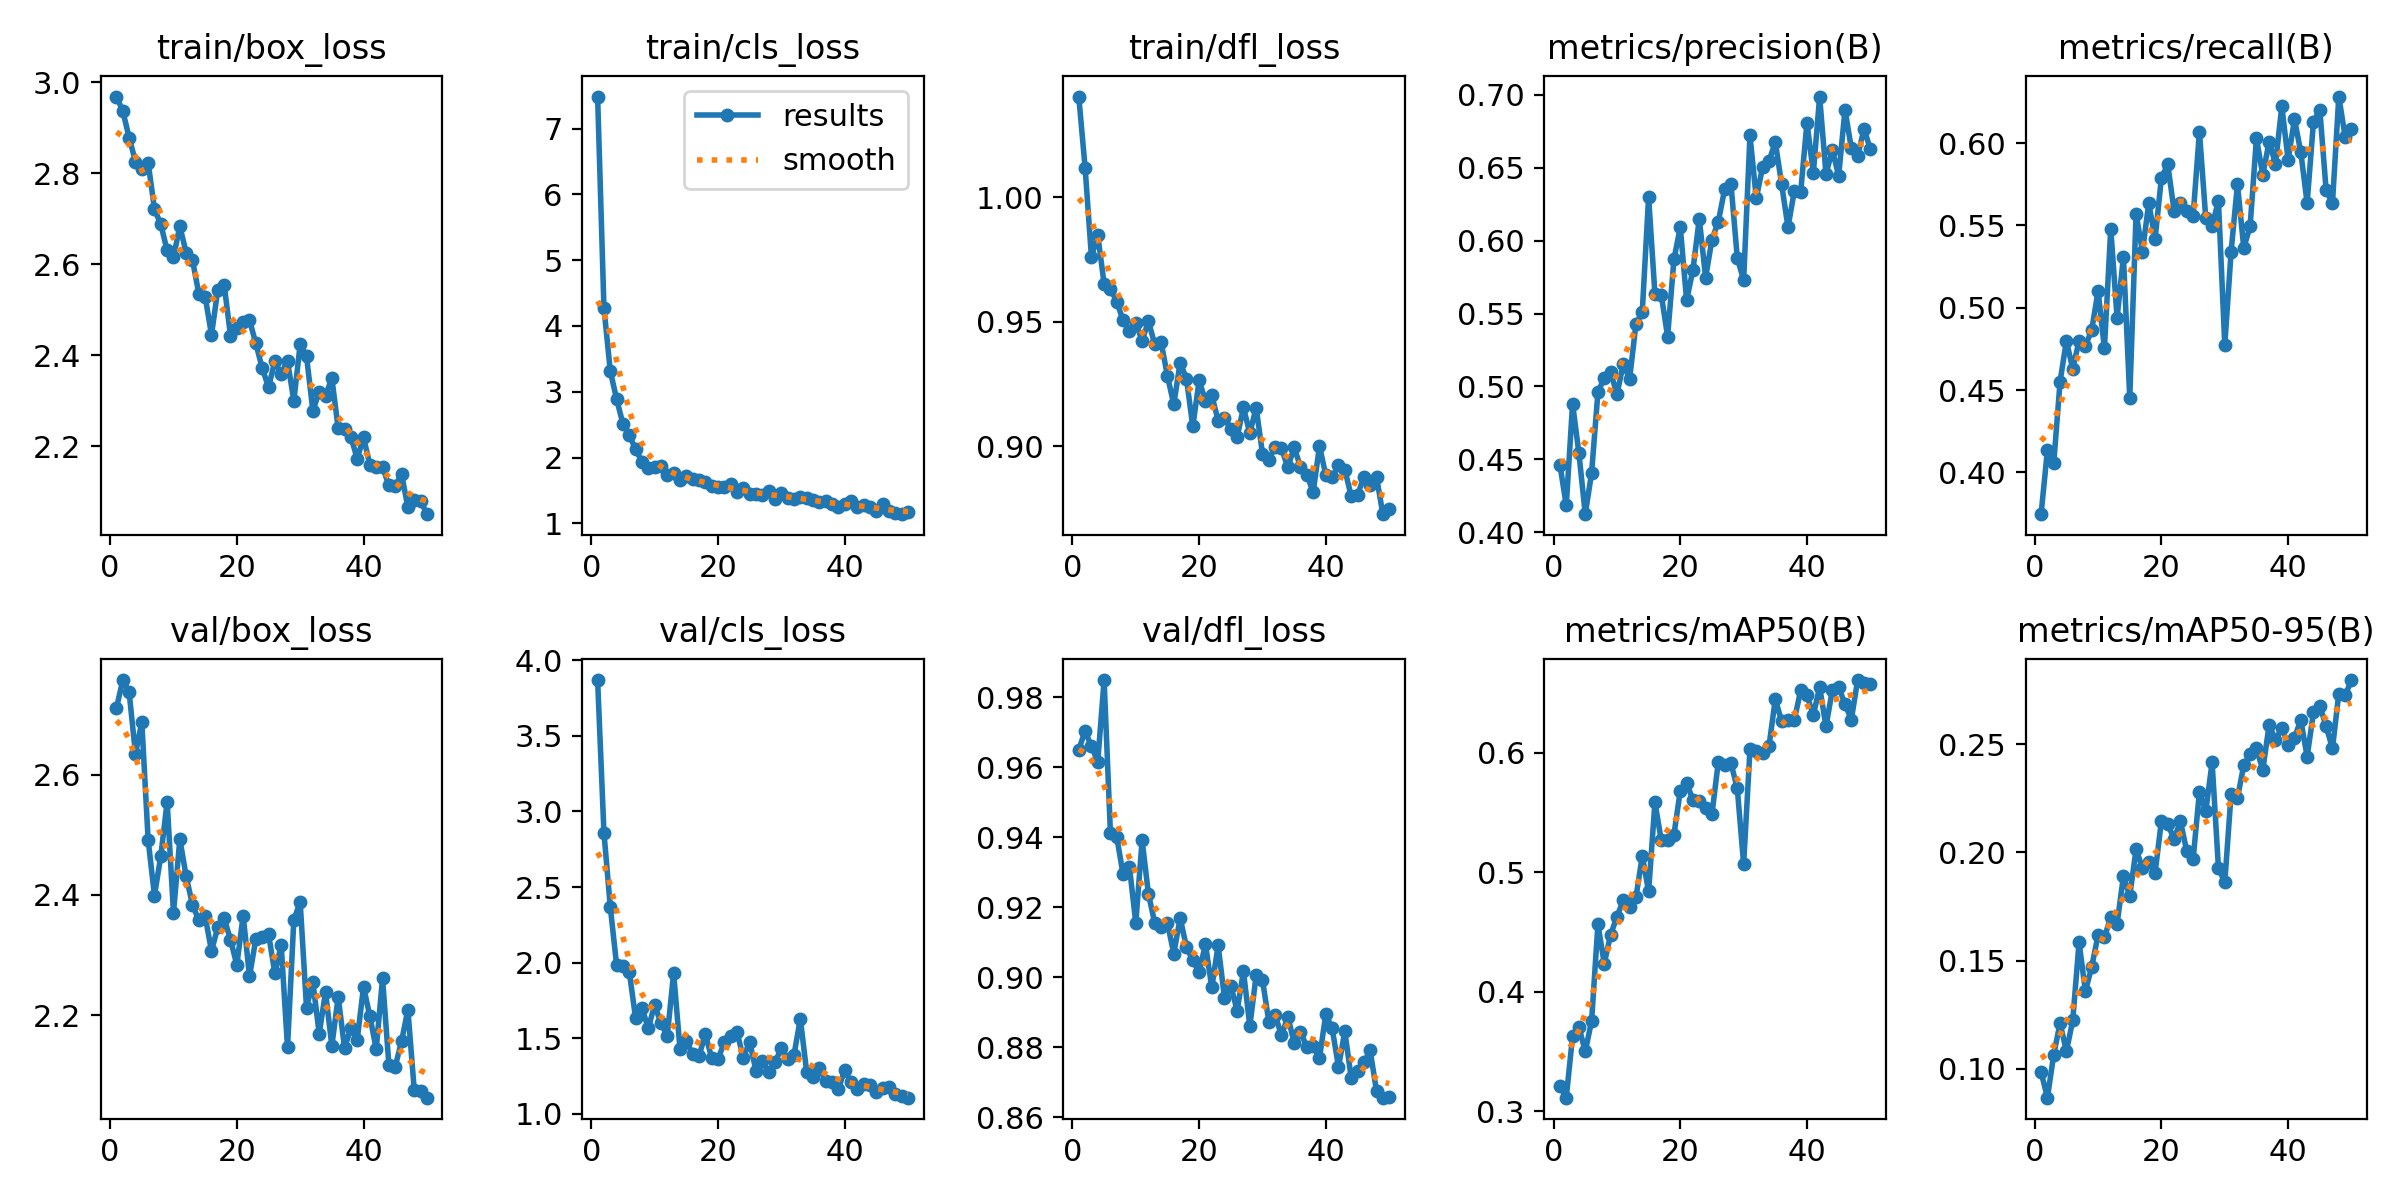

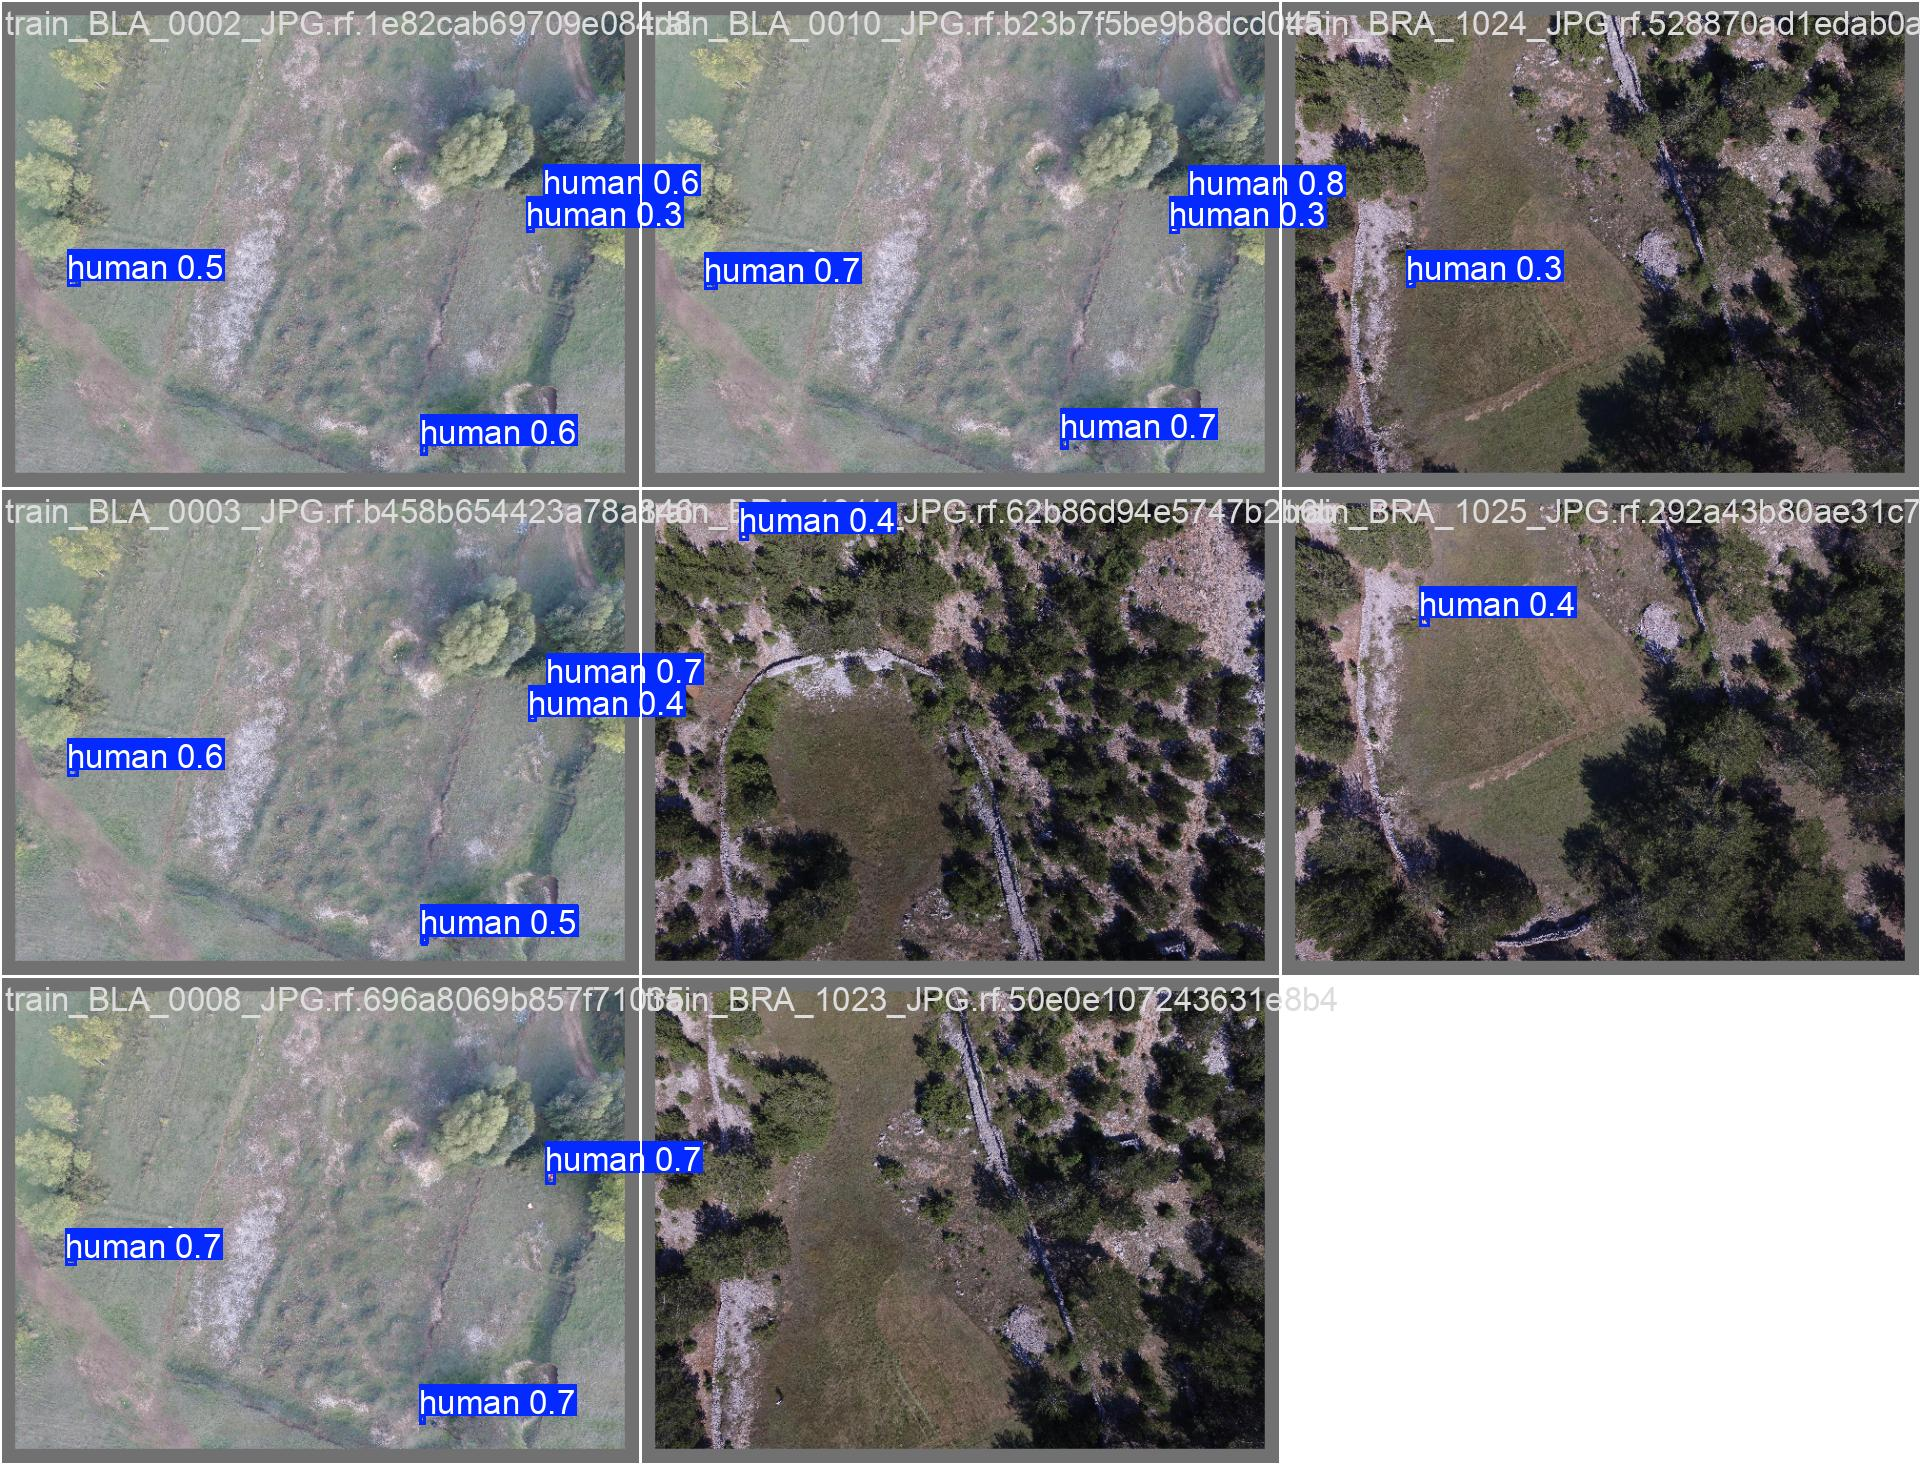

In [90]:
def show_results():
    # Показать автоматически сгенерированные графики
    display(Image(filename="runs/detect/train/results.png", width=1000))
    
    # Показать примеры валидации
    display(Image(filename="runs/detect/train/val_batch0_pred.jpg", width=800))

show_results()

## Валидация

In [91]:
def validate_model():
    metrics = model.val()
    print(f"\nРезультаты валидации:")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")

validate_model()

Ultralytics 8.3.134 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:1 (Tesla V100-SXM2-32GB, 32494MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3137.2±1297.9 MB/s, size: 4897.9 KB)


val: Scanning /home/v.chernodolya/introduction_to_ai/heridal/yolo_dataset/labels/val.cache... 197 images, 0 backgrounds, 0 corrupt: 100%|██████████| 197/197 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:03<00:00, 16.52it/s]


                   all        197        646      0.678      0.661      0.686      0.298
Speed: 0.3ms preprocess, 5.5ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train42

Результаты валидации:
mAP50: 0.6858
mAP50-95: 0.2982
Precision: 0.6777
Recall: 0.6606


## Пример детекции


image 1/1 /home/v.chernodolya/introduction_to_ai/heridal/yolo_dataset/images/val/train_GOR_3003_JPG.rf.e36080ecfb5a41dd06d3bfa0fc45461e.jpg: 480x640 1 human, 16.4ms
Speed: 2.8ms preprocess, 16.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


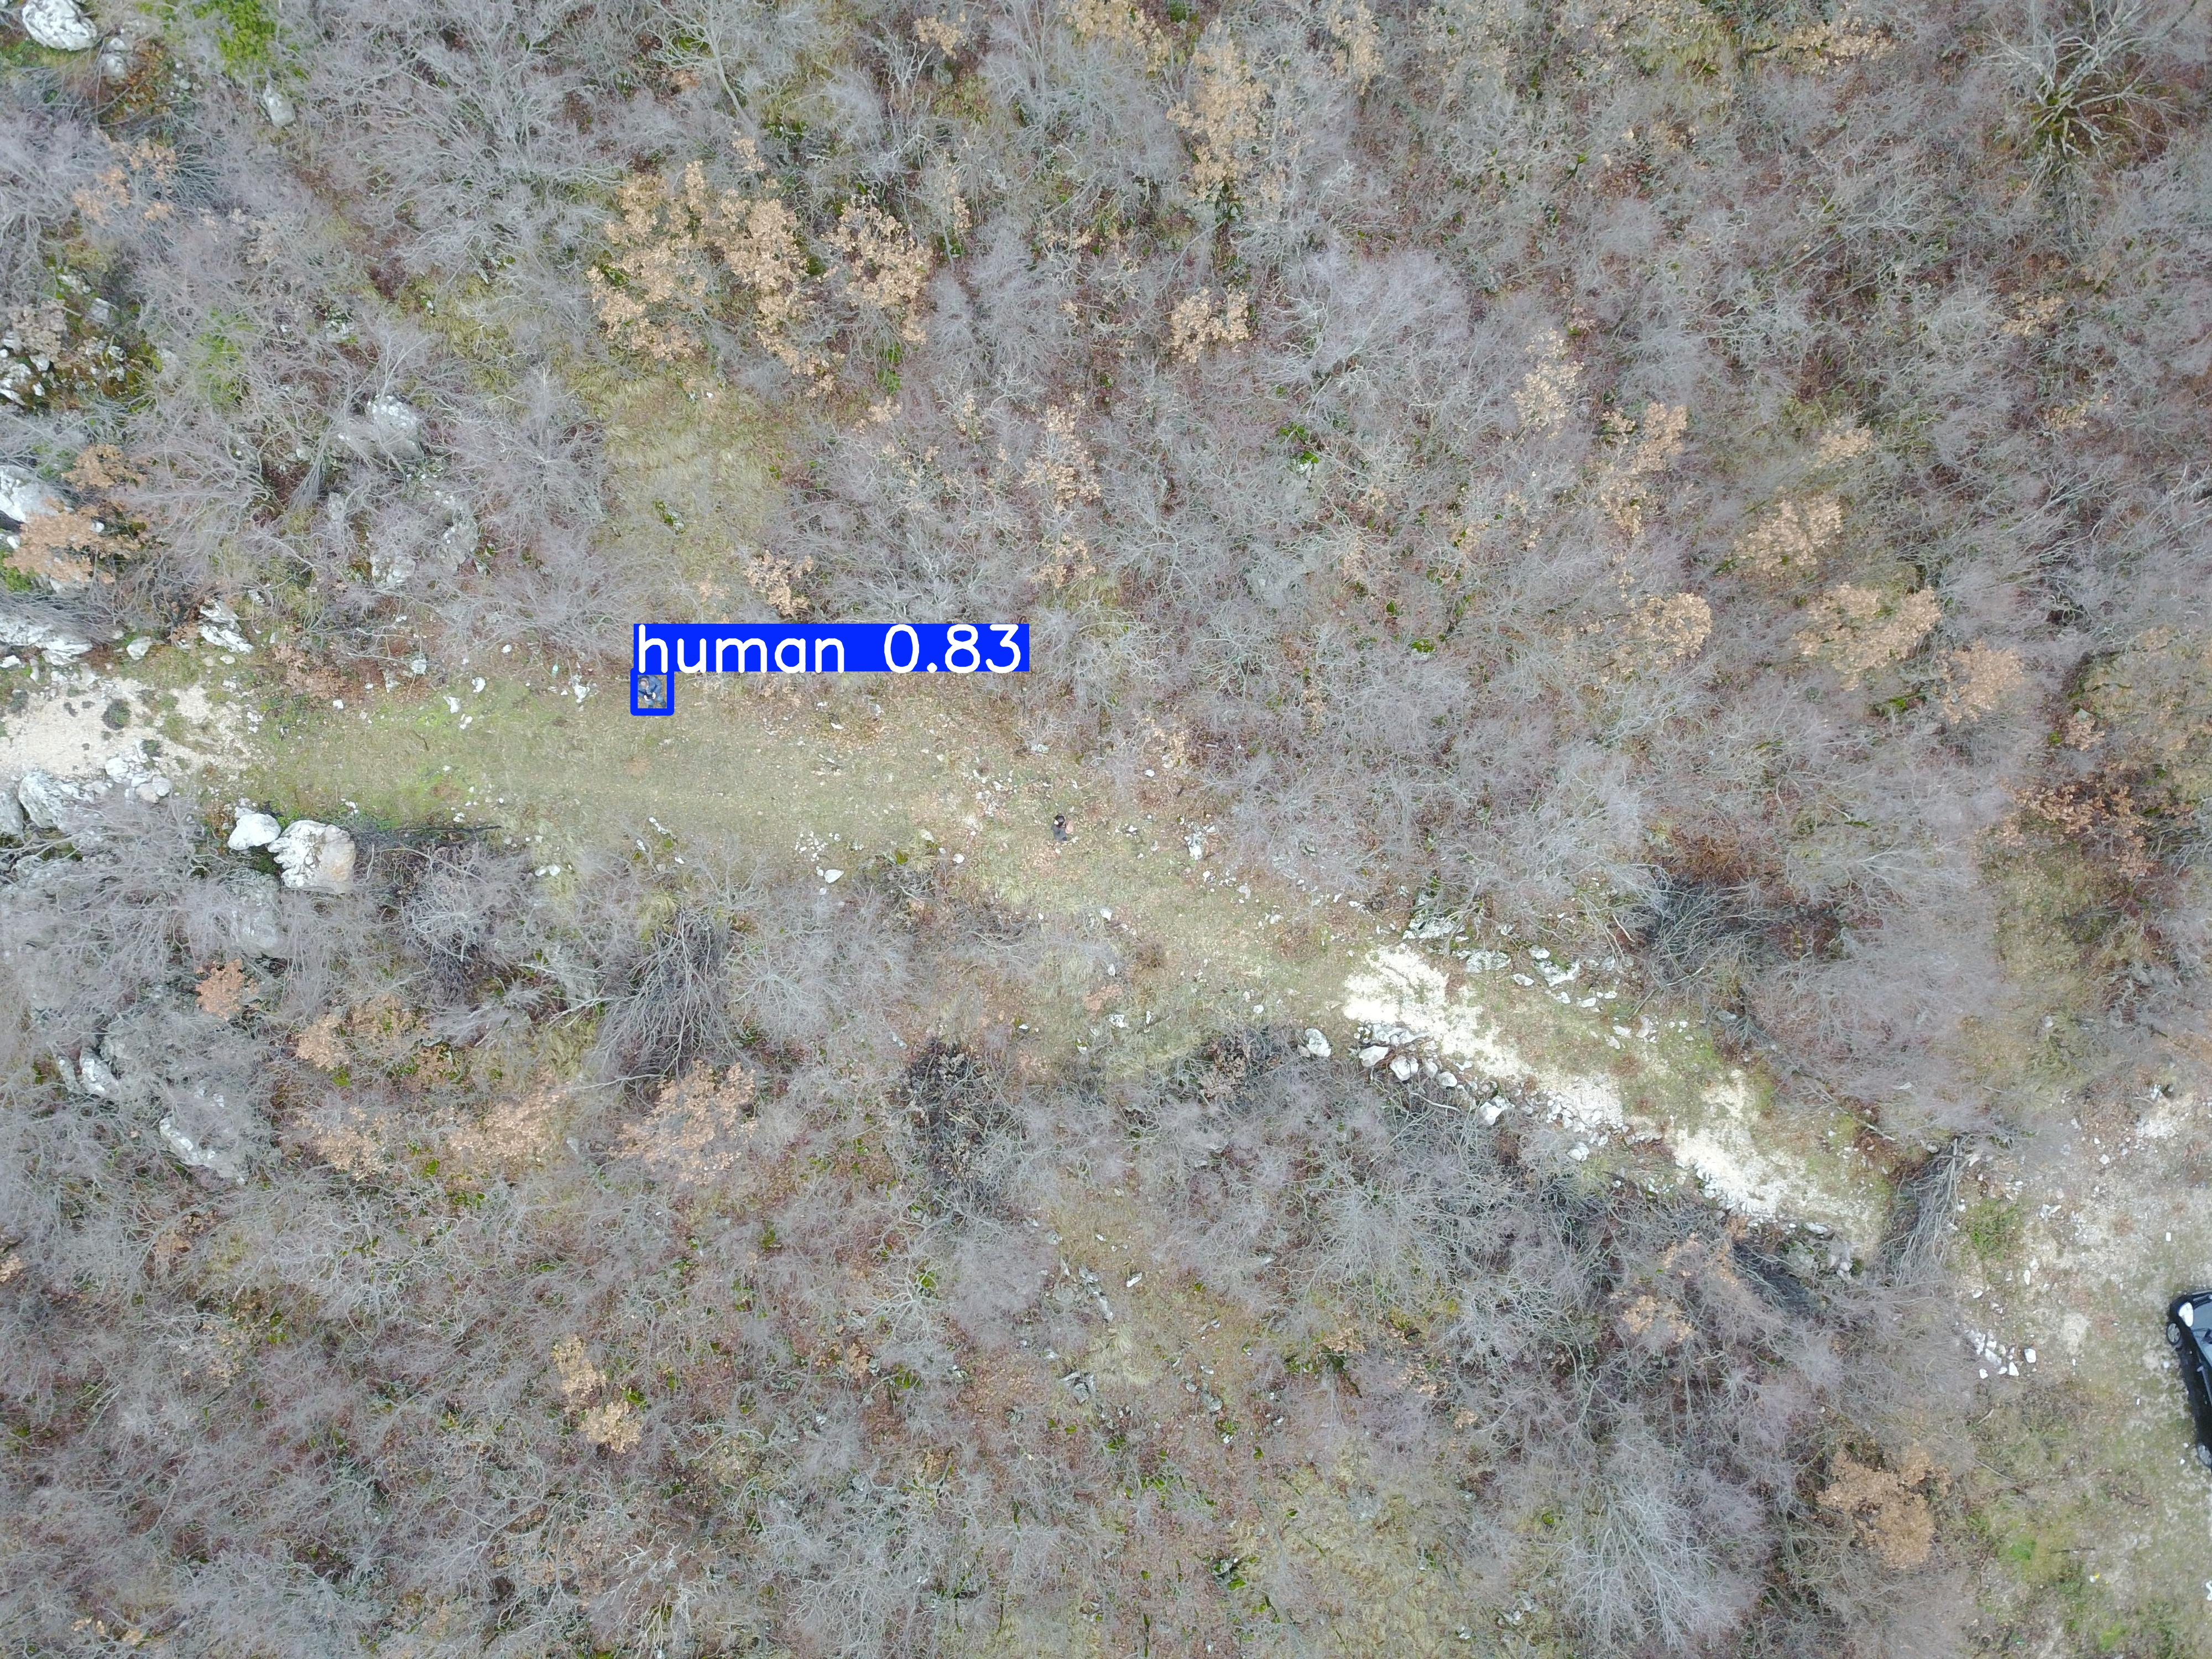

In [93]:
def run_detection():
    # Выбираем случайное изображение из валидационного набора
    import random
    val_images = [f for f in os.listdir("yolo_dataset/images/val") if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if not val_images:
        print("В валидационной папке нет изображений")
        return
    
    test_image = random.choice(val_images)
    test_image_path = os.path.join("yolo_dataset/images/val", test_image)
    
    # Выполняем детекцию
    results = model.predict(
        source=test_image_path,
        conf=0.5,
        save=True,
        project="runs/detect",
        name="predict",
        exist_ok=True
    )
    
    # Путь к сохраненному результату
    save_dir = "runs/detect/predict"
    result_image = os.path.join(save_dir, test_image)
    
    # Проверяем существование файла
    if os.path.exists(result_image):
        from IPython.display import Image, display
        display(Image(filename=result_image, width=800))
    else:
        print(f"Результат не найден по пути: {result_image}")

run_detection()